In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install -q tehran-stocks
!pip install nest_asyncio

In [ ]:
import tehran_stocks
from tehran_stocks import get_all_price, Stocks, update_group
import nest_asyncio; nest_asyncio.apply()
from tehran_stocks.download import get_all_price

get_all_price() # download and(or) update all prices

update_group(34) #download and(or) update Stocks in groupCode = 34 (Cars)

Stocks.get_group() # to see list of group codes

Download Finished.
updating group 34
group 34 updated


[]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text

# Load data

In [ ]:

df = pd.read_csv(
        '/content/drive/MyDrive/CWI_History.csv',
        parse_dates=['Date'],  # Ensure Date column is parsed as datetime
        dayfirst=True,         # Important for Iranian date format (day/month/year)
        encoding='utf-8'       # Handle Persian characters if any
)


# Sort by date (ascending)
df = df.sort_values('Date')

# Reset index after sorting
df = df.reset_index(drop=True)


In [ ]:
if df.isnull().sum().any():
    print("\nHandling missing values...")

In [ ]:
df.head()

,Unnamed: 0,Date,Weekday,Open,High,Low,Close,Adj Close,Volume
0,0,2010-01-02,Saturday,11208.0,11295.0,11208.0,11295.0,11295.2,60896653
1,1,2010-01-03,Sunday,11323.0,11366.0,11323.0,11351.0,11351.1,114461675
2,2,2010-01-04,Monday,11346.0,11346.0,11305.0,11305.0,11305.1,61449150
3,3,2010-01-05,Tuesday,11302.0,11326.0,11302.0,11307.0,11307.4,71811764
4,4,2010-01-06,Wednesday,11319.0,11375.0,11319.0,11375.0,11375.4,99254905


# calculate Indicators

In [ ]:
def calculate_indicators(df):
    # Volatility of Closing Price (VCP)
    df['VCP'] = df['Close'].pct_change() * 100

    # Volatility of Opening Price (VOP)
    df['VOP'] = df['Open'].pct_change() * 100

    # Turnover Rate (TR) - Simplified version
    df['TR'] = df['Volume'] / df['Volume'].rolling(30).mean()

    # Price-to-Earnings and Price-to-Book would need external data
    # For demonstration, we'll create dummy values
    df['PE'] = np.random.uniform(5, 25, len(df))
    df['PB'] = np.random.uniform(1, 5, len(df))

    # Volatility of PE and PB
    df['VPE'] = df['PE'].pct_change() * 100
    df['VPB'] = df['PB'].pct_change() * 100

    # Create labels for categorical variables
    df['VCP_label'] = np.where(df['VCP'] > 0, 'Up', 'Down')
    df['VOP_label'] = np.where(df['VOP'] > 0, 'Up', 'Down')
    df['TR_label'] = np.where(df['TR'] > 0.3, 'High', 'Low')  # Threshold adjustable
    df['VPE_label'] = np.where(df['VPE'] > 0, 'Up', 'Down')
    df['VPB_label'] = np.where(df['VPB'] > 0, 'Up', 'Down')

    return df

df = calculate_indicators(df)

In [ ]:
df.head()

,Unnamed: 0,Date,Weekday,Open,High,Low,Close,Adj Close,Volume,VCP,...,TR,PE,PB,VPE,VPB,VCP_label,VOP_label,TR_label,VPE_label,VPB_label
0,0,2010-01-02,Saturday,11208.0,11295.0,11208.0,11295.0,11295.2,60896653,NaN,...,NaN,7.604324,3.249265,NaN,NaN,Down,Down,Low,Down,Down
1,1,2010-01-03,Sunday,11323.0,11366.0,11323.0,11351.0,11351.1,114461675,0.495795,...,NaN,12.173689,2.481222,60.089027,-23.637433,Up,Up,Low,Up,Down
2,2,2010-01-04,Monday,11346.0,11346.0,11305.0,11305.0,11305.1,61449150,-0.405251,...,NaN,24.719526,3.910584,103.056989,57.607161,Down,Up,Low,Up,Up
3,3,2010-01-05,Tuesday,11302.0,11326.0,11302.0,11307.0,11307.4,71811764,0.017691,...,NaN,18.845026,1.069778,-23.764615,-72.644029,Up,Down,Low,Down,Down
4,4,2010-01-06,Wednesday,11319.0,11375.0,11319.0,11375.0,11375.4,99254905,0.601397,...,NaN,16.847693,3.878262,-10.598726,262.529489,Up,Up,Low,Down,Up


In [ ]:
def prepare_dataset(df):
    # Create target (next day's movement)
    df['y'] = df['VCP_label'].shift(-1)
    # df['y'] = np.where(df['y'] == 'Up', 1, 0)

    # Create feature columns (using label versions)
    features = df[[
        'VOP_label',
        'TR_label',
        'VCP_label',
        # 'PE',
        # 'PB
        # 'VPE_label',
        # 'VPB_label',
        # 'EI_label',
        # 'AM_label',
        # 'Reply'
    ]].copy()

    # Convert categorical features to numerical
    features = pd.get_dummies(features, drop_first=True)

    # Add numerical features
    # features['VCP'] = df['VCP']
    # features['EI'] = df['EI']
    # features['AM'] = df['AM']

    # Drop rows with missing values
    features['y'] = df['y']
    features = features.dropna()

    return features

features = prepare_dataset(df)

In [ ]:
features.head()

,VOP_label_Up,TR_label_Low,VCP_label_Up,y
0,False,True,False,Up
1,True,True,True,Down
2,True,True,False,Up
3,False,True,True,Up
4,True,True,True,Up


# Random Forest

In [ ]:
X = features.drop('y', axis=1)
y = features['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Model Accuracy: 0.62


# Extract Rules

In [ ]:
def extract_rules(model, feature_names):
    rules = []
    for tree in model.estimators_:
        rule = export_text(tree, feature_names=list(feature_names))
        rules.append(rule)
    return rules

feature_names = X.columns.tolist()
rules = extract_rules(model, feature_names)

# Print first 3 trees' rules
for i, rule in enumerate(rules[:3]):
    print(f"\n==== Decision Tree {i+1} ====")
    print(rule)


==== Decision Tree 1 ====
|--- VOP_label_Up <= 0.50
|   |--- TR_label_Low <= 0.50
|   |   |--- VCP_label_Up <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- VCP_label_Up >  0.50
|   |   |   |--- class: 1.0
|   |--- TR_label_Low >  0.50
|   |   |--- VCP_label_Up <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- VCP_label_Up >  0.50
|   |   |   |--- class: 1.0
|--- VOP_label_Up >  0.50
|   |--- TR_label_Low <= 0.50
|   |   |--- VCP_label_Up <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- VCP_label_Up >  0.50
|   |   |   |--- class: 1.0
|   |--- TR_label_Low >  0.50
|   |   |--- VCP_label_Up <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- VCP_label_Up >  0.50
|   |   |   |--- class: 0.0


==== Decision Tree 2 ====
|--- VCP_label_Up <= 0.50
|   |--- VOP_label_Up <= 0.50
|   |   |--- TR_label_Low <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- TR_label_Low >  0.50
|   |   |   |--- class: 0.0
|   |--- VOP_label_Up >  0.50
|   |   |--- TR_label_Low <= 0.50
|   |   |   |--- class: 0.0
|   |

In [ ]:
print(f'rules: {len(rules)}')
print(f'trees: {len(model.estimators_)}')

NameError: name 'rules' is not defined

# Create Kripke Structure

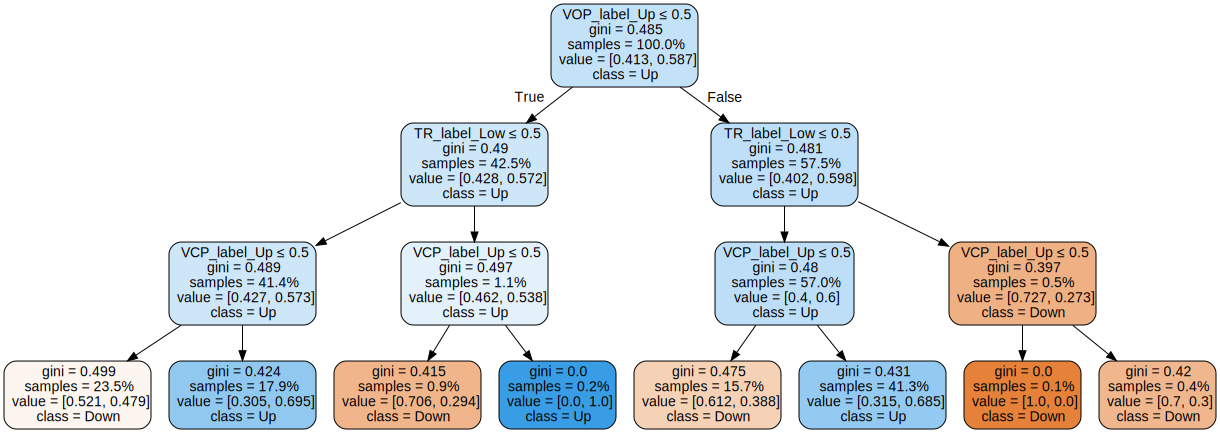

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Select one tree from your Random Forest (e.g., first tree)
tree = model.estimators_[0]

# Export as dot file
dot_data = export_graphviz(tree,
                          feature_names=X.columns,
                          class_names=['Down', 'Up'],  # Your target classes
                          filled=True,
                          rounded=True,
                          special_characters=True,
                          proportion=True)

# Create graph
graph = graphviz.Source(dot_data)
graph.render('iran_stock_tree')  # Saves as PDF
graph  # Displays in notebook

In [ ]:
# Get Gini importance from Random Forest
gini_importance = model.feature_importances_

# Get permutation importance (more reliable)
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30)

# Combine metrics
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Gini_Importance': gini_importance,
    'Permutation_Importance': perm_importance.importances_mean
})

# Normalize and rank
importance_df['Composite_Importance'] = (
    0.7 * importance_df['Permutation_Importance'] +
    0.3 * importance_df['Gini_Importance']
)
importance_df = importance_df.sort_values('Composite_Importance', ascending=False)

In [ ]:
importance_df

,Feature,Gini_Importance,Permutation_Importance,Composite_Importance
2,VCP_label_Up,0.880612,0.11983,0.348065
1,TR_label_Low,0.068867,0.00000,0.020660
0,VOP_label_Up,0.050521,0.00000,0.015156


In [ ]:
from collections import defaultdict

split_counts = defaultdict(int)
depth_counts = defaultdict(list)

for tree in model.estimators_:
    # Get feature usage per depth level
    tree_ = tree.tree_
    for node in range(tree_.node_count):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature = X.columns[tree_.feature[node]]
            depth = tree_.depth[node]
            split_counts[feature] += 1
            depth_counts[feature].append(depth)

# Calculate average depth of splits
avg_depth = {feat: np.mean(deps) for feat, deps in depth_counts.items()}
importance_df['Avg_Split_Depth'] = importance_df['Feature'].map(avg_depth)
importance_df['Split_Frequency'] = importance_df['Feature'].map(split_counts)

# Final ranking metric (earlier splits = more important)
importance_df['Structural_Importance'] = (
    importance_df['Composite_Importance'] *
    (1 / (1 + importance_df['Avg_Split_Depth'])))

NameError: name '_tree' is not defined

In [ ]:
# Get ordered features based on structural importance
ordered_features = importance_df.sort_values(
    'Composite_Importance',
    ascending=False
)['Feature'].tolist()

print("Feature Order for Kripke Construction:")
for i, feat in enumerate(ordered_features, 1):
    print(f"C{i}: {feat} (Importance: {importance_df.loc[importance_df['Feature'] == feat, 'Composite_Importance'].values[0]:.4f})")

Feature Order for Kripke Construction:
C1: VCP_label_Up (Importance: 0.3481)
C2: TR_label_Low (Importance: 0.0207)
C3: VOP_label_Up (Importance: 0.0152)


In [ ]:
kripke_features = []
for feature in ordered_features:
    # Get all possible values for the feature
    if 1==2:
    # if '_label' in feature:  # Categorical feature
      pass
        # values = df[feature.replace('_label','')].unique()
    else:  # Numerical feature (bin based on tree thresholds)
        thresholds = set()
        for tree in model.estimators_:
            tree_ = tree.tree_
            for node in range(tree_.node_count):
                if tree_.feature[node] == list(X.columns).index(feature):
                    thresholds.add(tree_.threshold[node])
        values = sorted(thresholds)

    kripke_features.append({
        'feature': feature,
        'values': values,
        'importance': importance_df.loc[importance_df['Feature'] == feature, 'Composite_Importance'].values[0]
    })

# Example output for state transitions
print("\nKripke State Transition Template:")
for i, feat in enumerate(kripke_features):
    print(f"State s{i} → s{i+1} transitions based on {feat['feature']}:")
    for val in feat['values'][:3]:  # Show first 3 values
        print(f"  - Condition: {feat['feature']} = {val:.2f}")
    if len(feat['values']) > 3:
        print(f"  - ... and {len(feat['values'])-3} more thresholds")


Kripke State Transition Template:
State s0 → s1 transitions based on VCP_label_Up:
  - Condition: VCP_label_Up = 0.50
State s1 → s2 transitions based on TR_label_Low:
  - Condition: TR_label_Low = 0.50
State s2 → s3 transitions based on VOP_label_Up:
  - Condition: VOP_label_Up = 0.50


In [ ]:
import numpy as np
from sklearn.tree import _tree

def build_kripke_structure(rf_model, feature_names, X_train):
    # 1. Feature Importance Ordering
    tree_depths = {}
    for i, tree in enumerate(rf_model.estimators_):
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                feature = feature_names[tree_.feature[node]]
                depth = _get_node_depth(tree_, node)
                if feature not in tree_depths:
                    tree_depths[feature] = []
                tree_depths[feature].append(depth)

    # Paper's exact importance metric (average split depth)
    feature_importance = {
        feat: np.mean(depths) for feat, depths in tree_depths.items()
    }
    ordered_features = sorted(feature_importance.keys(),
                            key=lambda x: feature_importance[x])

    # 2. State Construction
    states = {'s0': {'type': 'initial'}}
    transitions = []

    # Build state hierarchy
    current_states = ['s0']
    for i, feature in enumerate(ordered_features):
        next_states = []
        feature_values = _get_feature_thresholds(rf_model, feature, feature_names)

        for state in current_states:
            for j, value in enumerate(feature_values):
                new_state = f"s{len(states)}"
                states[new_state] = {
                    'feature': feature,
                    'value': value,
                    'level': i+1
                }
                transitions.append({
                    'from': state,
                    'to': new_state,
                    'condition': f"{feature} <= {value:.4f}" if j == 0
                               else f"{feature} > {feature_values[j-1]:.4f}",
                    'edge_type': 'intermediate' if i < len(ordered_features)-1
                                 else 'final'
                })
                next_states.append(new_state)

        current_states = next_states

    # 3. Terminal States (Up/Down)
    for state in current_states:
        # Get majority class for each terminal path
        terminal_class = _get_terminal_class(rf_model, states, transitions, state,
                                           ordered_features, X_train)
        states[state]['terminal'] = 'Up' if terminal_class == 1 else 'Down'

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

# Helper functions
def _get_node_depth(tree, node):
    depth = 0
    while node != 0:
        node = _find_parent(tree, node)
        depth += 1
    return depth

def _find_parent(tree, node):
    for parent in range(tree.node_count):
        if tree.children_left[parent] == node or tree.children_right[parent] == node:
            return parent
    return -1

def _get_feature_thresholds(rf_model, feature, feature_names):
    thresholds = set()
    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if (tree_.feature[node] != _tree.TREE_UNDEFINED and
                feature_names[tree_.feature[node]] == feature):
                thresholds.add(tree_.threshold[node])
    return sorted(thresholds)

def _get_terminal_class(rf_model, states, transitions, terminal_state,
                       ordered_features, X_train):
    # Reconstruct decision path
    path = []
    current_state = terminal_state
    while current_state != 's0':
        for t in transitions:
            if t['to'] == current_state:
                path.insert(0, t['condition'])
                current_state = t['from']
                break

    # Create mask for samples following this path
    mask = np.ones(len(X_train), dtype=bool)
    for condition in path:
        if '<=' in condition:
            feat, val = condition.split(' <= ')
            mask &= (X_train[feat] <= float(val))
        else:
            feat, val = condition.split(' > ')
            mask &= (X_train[feat] > float(val))

    # Get majority vote from all trees
    if mask.any():
        preds = np.array([tree.predict(X_train[mask]) for tree in rf_model.estimators_])
        return np.round(preds.mean())
    else:
        return 0  # Default to Down if no samples

In [ ]:
# After training Random Forest (as before)
kripke_model = build_kripke_structure(model, X.columns, X_train)

# Print structure summary
print(f"Kripke Structure with {len(kripke_model['states'])} states")
print("Feature order:", kripke_model['feature_order'])

# Sample transition
print("\nExample transition:")
print(kripke_model['transitions'][0])

# Export to NuSMV format
def export_nusmv(kripke_model):
    smv = "MODULE main\nVAR\n"
    smv += "    state: {" + ", ".join(kripke_model['states'].keys()) + "};\n\n"
    smv += "ASSIGN\n"
    smv += "    init(state) := s0;\n"
    smv += "    next(state) :=\n        case\n"

    for t in kripke_model['transitions']:
        smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"

    smv += "            TRUE : state;\n        esac;\n\n"

    # Add CTL properties
    terminal_up = [s for s in kripke_model['states']
                  if 'terminal' in kripke_model['states'][s]
                  and kripke_model['states'][s]['terminal'] == 'Up']
    smv += "-- Verification Properties\n"
    smv += "SPEC EF (state in {" + ", ".join(terminal_up) + "});\n"

    return smv

print("\nNuSMV Code:\n", export_nusmv(kripke_model))

Kripke Structure with 4 states
Feature order: ['VOP_label_Up', 'TR_label_Low', 'VCP_label_Up']

Example transition:
{'from': 's0', 'to': 's1', 'condition': 'VOP_label_Up <= 0.5000', 'edge_type': 'intermediate'}

NuSMV Code:
 MODULE main
VAR
    state: {s0, s1, s2, s3};

ASSIGN
    init(state) := s0;
    next(state) :=
        case
            state = s0 & VOP_label_Up <= 0.5000 : s1;
            state = s1 & TR_label_Low <= 0.5000 : s2;
            state = s2 & VCP_label_Up <= 0.5000 : s3;
            TRUE : state;
        esac;

-- Verification Properties
SPEC EF (state in {});



In [ ]:
def build_kripke_structure(rf_model, feature_names, X_train):
    # Initialize data structures
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []
    state_counter = 1

    # 1. Get feature importance order (by average split depth)
    feature_depths = defaultdict(list)
    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                feature = feature_names[tree_.feature[node]]
                depth = _get_node_depth(tree_, node)
                feature_depths[feature].append(depth)

    # Paper's importance metric (lower average depth = more important)
    feature_importance = {feat: np.mean(deps) for feat, deps in feature_depths.items()}
    ordered_features = sorted(feature_importance.keys(), key=lambda x: feature_importance[x])

    # 2. Build state hierarchy with binary branching
    for i, feature in enumerate(ordered_features):
        # Get current level states (filter properly)
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for current_state in current_states:
            # Create two child states for each decision
            left_state = f's{state_counter}'
            right_state = f's{state_counter+1}'

            states.update({
                left_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} <= 0.5"
                },
                right_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} > 0.5"
                }
            })

            transitions.extend([
                {'from': current_state, 'to': left_state, 'condition': states[left_state]['condition']},
                {'from': current_state, 'to': right_state, 'condition': states[right_state]['condition']}
            ])

            state_counter += 2

    # 3. Add terminal states and labels
    terminal_counter = 0
    last_level = max([data.get('level', 0) for data in states.values()])
    final_states = [s for s, data in states.items() if data.get('level', -1) == last_level]

    for final_state in final_states:
        terminal_up = f't{terminal_counter}_up'
        terminal_down = f't{terminal_counter}_down'
        terminal_counter += 1

        states.update({
            terminal_up: {'type': 'terminal', 'label': 'Up'},
            terminal_down: {'type': 'terminal', 'label': 'Down'}
        })

        # Connect final states to terminals
        path_conditions = _trace_path_conditions(final_state, states, transitions)
        up_prob = _calculate_path_probability(rf_model, path_conditions, X_train)

        if up_prob > 0.5:
            transitions.append({'from': final_state, 'to': terminal_up, 'condition': 'TRUE'})
        else:
            transitions.append({'from': final_state, 'to': terminal_down, 'condition': 'TRUE'})

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

def _trace_path_conditions(state, states, transitions):
    """Trace back through transitions to get all conditions leading to a state"""
    path = []
    current = state
    while current != 's0':
        for t in transitions:
            if t['to'] == current:
                path.append(t['condition'])
                current = t['from']
                break
    return path[::-1]  # Return in order from s0

def _calculate_path_probability(rf_model, conditions, X_train):
    """Calculate probability of Up classification for a given path"""
    if not conditions:
        return 0.0

    mask = np.ones(len(X_train), dtype=bool)
    for cond in conditions:
        if '<=' in cond:
            feat, val = cond.split(' <= ')
            mask &= (X_train[feat] <= float(val))
        else:
            feat, val = cond.split(' > ')
            mask &= (X_train[feat] > float(val))

    if not mask.any():
        return 0.0

    preds = np.mean([tree.predict(X_train[mask]) for tree in rf_model.estimators_])
    return float(preds)

In [ ]:
# After training Random Forest (as before)
# kripke_model = build_kripke_structure(model, X.columns, X_train)

# # Print structure summary
# print(f"Kripke Structure with {len(kripke_model['states'])} states")
# print("Feature order:", kripke_model['feature_order'])

# # Sample transition
# print("\nExample transition:")
# print(kripke_model['transitions'][0])



# After training Random Forest
kripke_model = build_kripke_structure(model, X.columns, X_train)

# Print structure
print(f"Features in order: {kripke_model['feature_order']}")
print(f"States {len(kripke_model['states'])}):")
for s, data in kripke_model['states'].items():
    print(f"  {s}: {data}")

print("\nTransitions:")
for t in kripke_model['transitions']:
    print(f"  {t['from']} --[{t['condition']}]--> {t['to']}")

# Export to NuSMV format
def export_nusmv(kripke_model):
    smv = "MODULE main\nVAR\n"
    smv += "    state: {" + ", ".join(kripke_model['states'].keys()) + "};\n\n"
    smv += "ASSIGN\n"
    smv += "    init(state) := s0;\n"
    smv += "    next(state) :=\n        case\n"

    for t in kripke_model['transitions']:
        smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"

    smv += "            TRUE : state;\n        esac;\n\n"

    # Add CTL properties
    terminal_up = [s for s in kripke_model['states']
                  if 'terminal' in kripke_model['states'][s]
                  and kripke_model['states'][s]['terminal'] == 'Up']
    smv += "-- Verification Properties\n"
    smv += "SPEC EF (state in {" + ", ".join(terminal_up) + "});\n"

    return smv

print("\nNuSMV Code:\n", export_nusmv(kripke_model))

Features in order: ['VOP_label_Up', 'TR_label_Low', 'VCP_label_Up']
States 31):
  s0: {'type': 'initial', 'level': 0}
  s1: {'type': 'decision', 'feature': 'VOP_label_Up', 'level': 1, 'condition': 'VOP_label_Up <= 0.5'}
  s2: {'type': 'decision', 'feature': 'VOP_label_Up', 'level': 1, 'condition': 'VOP_label_Up > 0.5'}
  s3: {'type': 'decision', 'feature': 'TR_label_Low', 'level': 2, 'condition': 'TR_label_Low <= 0.5'}
  s4: {'type': 'decision', 'feature': 'TR_label_Low', 'level': 2, 'condition': 'TR_label_Low > 0.5'}
  s5: {'type': 'decision', 'feature': 'TR_label_Low', 'level': 2, 'condition': 'TR_label_Low <= 0.5'}
  s6: {'type': 'decision', 'feature': 'TR_label_Low', 'level': 2, 'condition': 'TR_label_Low > 0.5'}
  s7: {'type': 'decision', 'feature': 'VCP_label_Up', 'level': 3, 'condition': 'VCP_label_Up <= 0.5'}
  s8: {'type': 'decision', 'feature': 'VCP_label_Up', 'level': 3, 'condition': 'VCP_label_Up > 0.5'}
  s9: {'type': 'decision', 'feature': 'VCP_label_Up', 'level': 3, 'con

In [ ]:
def build_kripke_structure(rf_model, feature_names, X_data):
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []
    state_counter = 1

    # Get feature importance order
    feature_depths = defaultdict(list)
    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                feature = feature_names[tree_.feature[node]]
                depth = _get_node_depth(tree_, node)
                feature_depths[feature].append(depth)

    ordered_features = sorted(feature_depths.keys(),
                            key=lambda x: np.mean(feature_depths[x]))

    # Build state hierarchy
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for current_state in current_states:
            left_state = f's{state_counter}'
            right_state = f's{state_counter+1}'

            states.update({
                left_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} <= 0.5"
                },
                right_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} > 0.5"
                }
            })

            transitions.extend([
                {'from': current_state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': current_state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

            state_counter += 2

    # Add SINGLE terminal state
    terminal_up = 'UP'  # Single terminal state
    terminal_down = 'DOWN'  # For completeness, though paper focuses on UP
    states.update({
        terminal_up: {'type': 'terminal', 'label': 'Up'},
        terminal_down: {'type': 'terminal', 'label': 'Down'}
    })

    # Connect all final states to appropriate terminal
    last_level = max([data.get('level', 0) for data in states.values()])
    final_states = [s for s, data in states.items() if data.get('level', -1) == last_level]

    for final_state in final_states:
        path_conditions = _trace_path_conditions(final_state, transitions)
        mask = _create_mask(X_data, path_conditions)

        if mask.any():
            pred = np.mean([tree.predict(X_data[mask]) for tree in rf_model.estimators_])
            terminal = terminal_up if pred > 0.5 else terminal_down
            transitions.append({'from': final_state, 'to': terminal, 'condition': 'TRUE'})

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

def _trace_path_conditions(target_state, transitions):
    """Trace back through transitions to get all conditions"""
    path = []
    current = target_state
    while current != 's0':
        for t in transitions:
            if t['to'] == current:
                path.append(t['condition'])
                current = t['from']
                break
    return path[::-1]  # Return in order from s0

def _create_mask(X_data, conditions):
    """Create boolean mask for samples matching path conditions"""
    mask = np.ones(len(X_data), dtype=bool)
    for cond in conditions:
        if '<=' in cond:
            feat, val = cond.split(' <= ')
            mask &= (X_data[feat] <= float(val))
        else:
            feat, val = cond.split(' > ')
            mask &= (X_data[feat] > float(val))
    return mask

In [ ]:
def export_nusmv(kripke_model):
    smv = "MODULE main\nVAR\n"
    smv += "    state: {" + ", ".join(
        ['s0'] +
        sorted([s for s in kripke_model['states'] if s.startswith('s')],
               key=lambda x: int(x[1:])) +
        ["UP", "DOWN"]
    ) + "};\n\n"

    # Add feature variables
    for feat in kripke_model['feature_order']:
        smv += f"    {feat}: boolean;\n"

    smv += "\nASSIGN\n"
    smv += "    init(state) := s0;\n"

    # Add feature initializations
    for feat in kripke_model['feature_order']:
        smv += f"    init({feat}) := FALSE;\n"

    smv += "\n    next(state) :=\n        case\n"

    # Add transitions (sorted properly)
    for t in sorted([t for t in kripke_model['transitions'] if t['to'] not in ['UP', 'DOWN']],
                   key=lambda x: (int(x['from'][1:]), int(x['to'][1:]))):
        smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"

    # Add terminal transitions
    for t in [t for t in kripke_model['transitions'] if t['to'] in ['UP', 'DOWN']]:
        smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"

    smv += "            TRUE : state;\n        esac;\n\n"

    # Verification property
    smv += "-- Verification Property\n"
    smv += "SPEC EF (state = UP);\n"

    return smv

In [ ]:
kripke_model = build_kripke_structure(model, X.columns, X_train)
nusmv_code = export_nusmv(kripke_model)
print(nusmv_code)

MODULE main
VAR
    state: {s0, s0, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, UP, DOWN};

    VOP_label_Up: boolean;
    TR_label_Low: boolean;
    VCP_label_Up: boolean;

ASSIGN
    init(state) := s0;
    init(VOP_label_Up) := FALSE;
    init(TR_label_Low) := FALSE;
    init(VCP_label_Up) := FALSE;

    next(state) :=
        case
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s1 & TR_label_Low <= 0.5 : s3;
            state = s1 & TR_label_Low > 0.5 : s4;
            state = s2 & TR_label_Low <= 0.5 : s5;
            state = s2 & TR_label_Low > 0.5 : s6;
            state = s3 & VCP_label_Up <= 0.5 : s7;
            state = s3 & VCP_label_Up > 0.5 : s8;
            state = s4 & VCP_label_Up <= 0.5 : s9;
            state = s4 & VCP_label_Up > 0.5 : s10;
            state = s5 & VCP_label_Up <= 0.5 : s11;
            state = s5 & VCP_label_Up > 0.5 : s12;
            state = s6 & VCP_label_Up 

In [ ]:
def build_kripke_structure(rf_model, feature_names, X_data):
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []
    state_counter = 1

    # Get feature importance order
    feature_depths = defaultdict(list)
    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                feature = feature_names[tree_.feature[node]]
                depth = _get_node_depth(tree_, node)
                feature_depths[feature].append(depth)

    ordered_features = sorted(feature_depths.keys(),
                            key=lambda x: np.mean(feature_depths[x]))

    # Build state hierarchy
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for current_state in current_states:
            left_state = f's{state_counter}'
            right_state = f's{state_counter+1}'

            states.update({
                left_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} <= 0.5"
                },
                right_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} > 0.5"
                }
            })

            transitions.extend([
                {'from': current_state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': current_state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

            state_counter += 2

    # Add single terminal states
    states.update({
        'UP': {'type': 'terminal', 'label': 'Up'},
        'DOWN': {'type': 'terminal', 'label': 'Down'}
    })

    # Connect all final states to appropriate terminal
    last_level = max([data.get('level', 0) for data in states.values()])
    final_states = [s for s, data in states.items() if data.get('level', -1) == last_level]

    for final_state in final_states:
        path_conditions = _trace_path_conditions(final_state, transitions)
        mask = _create_mask(X_data, path_conditions)

        if mask.any():
            pred = np.mean([tree.predict(X_data[mask]) for tree in rf_model.estimators_])
            terminal = 'UP' if pred > 0.5 else 'DOWN'
            transitions.append({'from': final_state, 'to': terminal, 'condition': 'TRUE'})

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

In [ ]:
def build_kripke_structure(rf_model, feature_names, X_data):
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []
    state_counter = 1

    # Get feature importance order
    feature_depths = defaultdict(list)
    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                feature = feature_names[tree_.feature[node]]
                depth = _get_node_depth(tree_, node)
                feature_depths[feature].append(depth)

    ordered_features = sorted(feature_depths.keys(),
                            key=lambda x: np.mean(feature_depths[x]))

    # Build state hierarchy
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for current_state in current_states:
            left_state = f's{state_counter}'
            right_state = f's{state_counter+1}'

            states.update({
                left_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} <= 0.5"
                },
                right_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} > 0.5"
                }
            })

            transitions.extend([
                {'from': current_state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': current_state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

            state_counter += 2

    # Add only UP terminal state
    states['UP'] = {'type': 'terminal', 'label': 'Up'}

    # Connect only positive paths to UP state
    last_level = max([data.get('level', 0) for data in states.values()])
    final_states = [s for s, data in states.items() if data.get('level', -1) == last_level]

    for final_state in final_states:
        path_conditions = _trace_path_conditions(final_state, transitions)
        mask = _create_mask(X_data, path_conditions)

        if mask.any():
            pred = np.mean([tree.predict(X_data[mask]) for tree in rf_model.estimators_])
            if pred > 0.5:  # Only create transitions to UP
                transitions.append({'from': final_state, 'to': 'UP', 'condition': 'TRUE'})

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

def export_nusmv(kripke_model):
    smv = "MODULE main\nVAR\n"
    smv += "    state: {" + ", ".join(['s0'] +
           sorted([s for s in kripke_model['states'] if s.startswith('s')],
                  key=lambda x: int(x[1:])) +
           ["UP"]) + "};\n\n"

    # Add feature variables
    for feat in kripke_model['feature_order']:
        smv += f"    {feat}: boolean;\n"

    smv += "\nASSIGN\n"
    smv += "    init(state) := s0;\n"

    # Add feature initializations
    for feat in kripke_model['feature_order']:
        smv += f"    init({feat}) := FALSE;\n"

    smv += "\n    next(state) :=\n        case\n"

    # Add all transitions
    for t in sorted(kripke_model['transitions'],
                   key=lambda x: (int(x['from'][1:]), int(x['to'][1:]) if x['to'].startswith('s') else 0)):
        smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"

    smv += "            TRUE : state;\n        esac;\n\n"
    smv += "-- Verification Property\n"
    smv += "SPEC EF (state = UP);\n"

    return smv

kripke_model = build_kripke_structure(model, X.columns, X_train)
nusmv_code = export_nusmv(kripke_model)
print(nusmv_code)

MODULE main
VAR
    state: {s0, s0, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, UP};

    VOP_label_Up: boolean;
    TR_label_Low: boolean;
    VCP_label_Up: boolean;

ASSIGN
    init(state) := s0;
    init(VOP_label_Up) := FALSE;
    init(TR_label_Low) := FALSE;
    init(VCP_label_Up) := FALSE;

    next(state) :=
        case
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s1 & TR_label_Low <= 0.5 : s3;
            state = s1 & TR_label_Low > 0.5 : s4;
            state = s2 & TR_label_Low <= 0.5 : s5;
            state = s2 & TR_label_Low > 0.5 : s6;
            state = s3 & VCP_label_Up <= 0.5 : s7;
            state = s3 & VCP_label_Up > 0.5 : s8;
            state = s4 & VCP_label_Up <= 0.5 : s9;
            state = s4 & VCP_label_Up > 0.5 : s10;
            state = s5 & VCP_label_Up <= 0.5 : s11;
            state = s5 & VCP_label_Up > 0.5 : s12;
            state = s6 & VCP_label_Up <= 0.5

In [ ]:
def build_kripke_structure(rf_model, feature_names, X_data):
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []
    state_counter = 1

    # Get feature importance order
    feature_depths = defaultdict(list)
    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                feature = feature_names[tree_.feature[node]]
                depth = _get_node_depth(tree_, node)
                feature_depths[feature].append(depth)

    ordered_features = sorted(feature_depths.keys(),
                            key=lambda x: np.mean(feature_depths[x]))

    # Build state hierarchy
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for current_state in current_states:
            left_state = f's{state_counter}'
            right_state = f's{state_counter+1}'

            states.update({
                left_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} <= 0.5"
                },
                right_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} > 0.5"
                }
            })

            transitions.extend([
                {'from': current_state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': current_state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

            state_counter += 2

    # Add SINGLE terminal UP state
    states['UP'] = {'type': 'terminal', 'label': 'Up'}

    # Connect only positive paths to UP state
    last_level = max([data.get('level', 0) for data in states.values()])
    final_states = [s for s, data in states.items() if data.get('level', -1) == last_level]

    for final_state in final_states:
        path_conditions = _trace_path_conditions(final_state, transitions)
        mask = _create_mask(X_data, path_conditions)

        if mask.any():
            pred = np.mean([tree.predict(X_data[mask]) for tree in rf_model.estimators_])
            if pred > 0.5:  # Only create transitions to UP
                transitions.append({'from': final_state, 'to': 'UP', 'condition': 'TRUE'})
            # Negative paths just terminate (no transition)

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

def export_nusmv(kripke_model):
    # Collect all state names in order
    state_names = ['s0'] + \
                 sorted([s for s in kripke_model['states'] if s.startswith('s')],
                         key=lambda x: int(x[1:])) + \
                 ['UP']

    smv = f"MODULE main\nVAR\n    state: {{{', '.join(state_names)}}};\n\n"

    # Add feature variables
    for feat in kripke_model['feature_order']:
        smv += f"    {feat}: boolean;\n"

    smv += "\nASSIGN\n    init(state) := s0;\n"

    # Add feature initializations
    for feat in kripke_model['feature_order']:
        smv += f"    init({feat}) := FALSE;\n"

    smv += "\n    next(state) :=\n        case\n"

    # Add all transitions sorted by source state
    for t in sorted(kripke_model['transitions'],
                   key=lambda x: (int(x['from'][1:]),
                                int(x['to'][1:]) if x['to'].startswith('s') else float('inf'))):
        smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"

    smv += "            TRUE : state;\n        esac;\n\n"
    smv += "-- Verification Property\n"
    smv += "SPEC EF (state = UP);\n"

    return smv


kripke_model = build_kripke_structure(model, X.columns, X_train)
nusmv_code = export_nusmv(kripke_model)
print(nusmv_code)

MODULE main
VAR
    state: {s0, s0, s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, UP};

    VOP_label_Up: boolean;
    TR_label_Low: boolean;
    VCP_label_Up: boolean;

ASSIGN
    init(state) := s0;
    init(VOP_label_Up) := FALSE;
    init(TR_label_Low) := FALSE;
    init(VCP_label_Up) := FALSE;

    next(state) :=
        case
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s1 & TR_label_Low <= 0.5 : s3;
            state = s1 & TR_label_Low > 0.5 : s4;
            state = s2 & TR_label_Low <= 0.5 : s5;
            state = s2 & TR_label_Low > 0.5 : s6;
            state = s3 & VCP_label_Up <= 0.5 : s7;
            state = s3 & VCP_label_Up > 0.5 : s8;
            state = s4 & VCP_label_Up <= 0.5 : s9;
            state = s4 & VCP_label_Up > 0.5 : s10;
            state = s5 & VCP_label_Up <= 0.5 : s11;
            state = s5 & VCP_label_Up > 0.5 : s12;
            state = s6 & VCP_label_Up <= 0.5

In [ ]:
def build_kripke_3features(rf_model, feature_names, X_data):
    # Step 1: Order features by importance (C1, C2, C3)
    feature_importance = {f: np.mean([tree.feature_importances_[list(feature_names).index(f)]
                          for tree in rf_model.estimators_])
                          for f in feature_names}
    ordered_features = sorted(feature_importance.keys(),
                            key=lambda x: -feature_importance[x])[:3]  # Top 3 only

    # Initialize
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []

    # Step 2: Build states for each feature (3 levels)
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for state in current_states:
            left_state = f's{2*i + 1}'  # s1, s3, s5
            right_state = f's{2*i + 2}' # s2, s4, s6

            states.update({
                left_state: {'feature': feature, 'value': f"{feature} <= 0.5", 'level': i+1},
                right_state: {'feature': feature, 'value': f"{feature} > 0.5", 'level': i+1}
            })

            transitions.extend([
                {'from': state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

    # Step 3: Connect to UP (only if RF predicts Up)
    states['UP'] = {'type': 'terminal'}
    final_states = [s for s, data in states.items() if data.get('level') == 3]

    for final_state in final_states:
        path_conditions = [t['condition'] for t in transitions
                         if t['to'] == final_state]
        mask = np.all([X_data[eval(cond)] for cond in path_conditions], axis=0)

        if mask.any() and np.mean(rf_model.predict(X_data[mask])) > 0.5:
            transitions.append({'from': final_state, 'to': 'UP', 'condition': 'TRUE'})

    # Prune non-UP paths
    productive_states = {'UP'}.union(
        t['from'] for t in transitions if t['to'] == 'UP'
    )

    states = {s: data for s, data in states.items()
             if s in productive_states.union({'s0', 'UP'})}
    transitions = [t for t in transitions
                 if t['from'] in productive_states.union({'s0'})
                 and t['to'] in productive_states.union({'UP'})]

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }




def export_nusmv(kripke_model):
    # Get unique states in proper order
    state_list = ['s0']
    max_level = max([data.get('level', 0) for data in kripke_model['states'].values()])

    for level in range(1, max_level+1):
        state_list.extend(
            sorted([s for s, data in kripke_model['states'].items()
                   if data.get('level', -1) == level],
                  key=lambda x: int(x[1:]))
        )

    state_list.append('UP')

    smv = f"MODULE main\nVAR\n    state: {{{', '.join(state_list)}}};\n\n"

    # Add feature variables
    for feat in kripke_model['feature_order']:
        smv += f"    {feat}: boolean;\n"

    smv += "\nASSIGN\n    init(state) := s0;\n"

    # Add feature initializations
    for feat in kripke_model['feature_order']:
        smv += f"    init({feat}) := FALSE;\n"

    smv += "\n    next(state) :=\n        case\n"

    # Add transitions in order
    for level in range(max_level+1):
        level_states = [s for s in state_list
                       if s == 's0' or kripke_model['states'].get(s, {}).get('level') == level]

        for state in level_states:
            state_transitions = [t for t in kripke_model['transitions'] if t['from'] == state]
            for t in sorted(state_transitions, key=lambda x: x['to']):
                smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"

    smv += "            TRUE : state;\n        esac;\n\n"
    smv += "-- Verification Property\n"
    smv += "SPEC EF (state = UP);\n"

    return smv


kripke_model = build_kripke_structure(model, X.columns, X_train)
nusmv_code = export_nusmv(kripke_model)
print(nusmv_code)

MODULE main
VAR
    state: {s0, s1, s2, s3, s4, s5, s6, s8, s10, s12, s14, UP};

    VOP_label_Up: boolean;
    TR_label_Low: boolean;
    VCP_label_Up: boolean;

ASSIGN
    init(state) := s0;
    init(VOP_label_Up) := FALSE;
    init(TR_label_Low) := FALSE;
    init(VCP_label_Up) := FALSE;

    next(state) :=
        case
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s1 & TR_label_Low <= 0.5 : s3;
            state = s1 & TR_label_Low > 0.5 : s4;
            state = s2 & TR_label_Low <= 0.5 : s5;
            state = s2 & TR_label_Low > 0.5 : s6;
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s3 & VCP_label_Up > 0.5 : s8;
            state = s4 & VCP_label_Up > 0.5 : s10;
            state = s5 & VCP_label_Up > 0.5 : s12;
            state 

In [ ]:
def build_kripke_structure(rf_model, feature_names, X_data):
    # ... (previous code to build states/transitions) ...

    # --- NEW: Prune non-UP paths ---
    # Step 1: Find all states that can reach UP
    upstream_states = set()
    queue = ["UP"]  # Start from UP and traverse backward

    while queue:
        current_state = queue.pop(0)
        for transition in kripke_model['transitions']:
            if transition['to'] == current_state:
                upstream_states.add(transition['from'])
                queue.append(transition['from'])

    # Step 2: Filter states and transitions
    kripke_model['states'] = {
        s: data for s, data in kripke_model['states'].items()
        if s in upstream_states or s == "UP" or s == "s0"
    }

    kripke_model['transitions'] = [
        t for t in kripke_model['transitions']
        if t['from'] in upstream_states or t['from'] == "s0"
    ]

    return kripke_model









def export_nusmv(kripke_model):
    # Get unique states in proper order
    state_list = ['s0']
    max_level = max([data.get('level', 0) for data in kripke_model['states'].values()])

    for level in range(1, max_level + 1):
        state_list.extend(
            sorted([s for s, data in kripke_model['states'].items()
                   if data.get('level', -1) == level],
                  key=lambda x: int(x[1:]))
        )

    state_list.append('UP')  # Only one UP state

    smv = f"MODULE main\nVAR\n    state: {{{', '.join(state_list)}}};\n\n"

    # Add feature variables (boolean for NuSMV)
    for feat in kripke_model['feature_order']:
        smv += f"    {feat}: boolean;\n"

    smv += "\nASSIGN\n    init(state) := s0;\n"

    # Initialize all features to FALSE (default)
    for feat in kripke_model['feature_order']:
        smv += f"    init({feat}) := FALSE;\n"

    smv += "\n    next(state) :=\n        case\n"

    # Track transitions to avoid duplicates
    seen_transitions = set()

    for t in kripke_model['transitions']:
        transition_key = (t['from'], t['condition'], t['to'])

        if transition_key not in seen_transitions:
            smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"
            seen_transitions.add(transition_key)

    smv += "            TRUE : state;\n        esac;\n\n"

    # Verification Property: Can we reach UP?
    smv += "-- Verification Property\n"
    smv += "SPEC EF (state = UP);\n"

    return smv










kripke_model = build_kripke_structure(model, X.columns, X_train)
nusmv_code = export_nusmv(kripke_model)
print(nusmv_code)

MODULE main
VAR
    state: {s0, s1, s2, s3, s4, s5, s6, s8, s10, s12, s14, UP};

    VOP_label_Up: boolean;
    TR_label_Low: boolean;
    VCP_label_Up: boolean;

ASSIGN
    init(state) := s0;
    init(VOP_label_Up) := FALSE;
    init(TR_label_Low) := FALSE;
    init(VCP_label_Up) := FALSE;

    next(state) :=
        case
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s1 & TR_label_Low <= 0.5 : s3;
            state = s1 & TR_label_Low > 0.5 : s4;
            state = s2 & TR_label_Low <= 0.5 : s5;
            state = s2 & TR_label_Low > 0.5 : s6;
            state = s3 & VCP_label_Up <= 0.5 : s7;
            state = s3 & VCP_label_Up > 0.5 : s8;
            state = s4 & VCP_label_Up <= 0.5 : s9;
            state = s4 & VCP_label_Up > 0.5 : s10;
            state = s5 & VCP_label_Up <= 0.5 : s11;
            state = s5 & VCP_label_Up > 0.5 : s12;
            state = s6 & VCP_label_Up <= 0.5 : s13;
            st

In [ ]:
def build_kripke_structure_up_paths_only(rf_model, feature_names, X_data):
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []
    state_counter = 1

    # Get feature importance order
    feature_depths = defaultdict(list)
    for tree in rf_model.estimators_:
        tree_ = tree.tree_
        for node in range(tree_.node_count):
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                feature = feature_names[tree_.feature[node]]
                depth = _get_node_depth(tree_, node)
                feature_depths[feature].append(depth)

    ordered_features = sorted(feature_depths.keys(),
                            key=lambda x: np.mean(feature_depths[x]))

    # Track which states can reach UP
    productive_states = set()

    # Build states level by level
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for current_state in current_states:
            left_state = f's{state_counter}'
            right_state = f's{state_counter+1}'
            state_counter += 2

            # Only add states if they can eventually reach UP
            states.update({
                left_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} <= 0.5"
                },
                right_state: {
                    'type': 'decision',
                    'feature': feature,
                    'level': i+1,
                    'condition': f"{feature} > 0.5"
                }
            })

            # Temporarily add transitions
            transitions.extend([
                {'from': current_state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': current_state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

    # Add UP state
    states['UP'] = {'type': 'terminal', 'label': 'Up'}

    # Connect final states to UP based on predictions
    last_level = max([data.get('level', 0) for data in states.values()])
    final_states = [s for s, data in states.items() if data.get('level', -1) == last_level]

    for final_state in final_states:
        path_conditions = _trace_path_conditions(final_state, transitions)
        mask = _create_mask(X_data, path_conditions)

        if mask.any():
            pred = np.mean([tree.predict(X_data[mask]) for tree in rf_model.estimators_])
            if pred > 0.5:
                transitions.append({'from': final_state, 'to': 'UP', 'condition': 'TRUE'})
                productive_states.add(final_state)

    # Backward pass to mark productive states
    changed = True
    while changed:
        changed = False
        for t in transitions:
            if t['to'] in productive_states and t['from'] not in productive_states:
                productive_states.add(t['from'])
                changed = True

    # Filter to only productive states and their transitions
    states = {s: data for s, data in states.items()
              if s in productive_states or s == 's0' or s == 'UP'}
    transitions = [t for t in transitions
                  if t['from'] in productive_states and t['to'] in productive_states]

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }




def export_nusmv(kripke_model):
    # Get unique states in proper order
    state_list = ['s0']
    max_level = max([data.get('level', 0) for data in kripke_model['states'].values()])

    for level in range(1, max_level + 1):
        state_list.extend(
            sorted([s for s, data in kripke_model['states'].items()
                   if data.get('level', -1) == level],
                  key=lambda x: int(x[1:]))
        )

    state_list.append('UP')  # Only one UP state

    smv = f"MODULE main\nVAR\n    state: {{{', '.join(state_list)}}};\n\n"

    # Add feature variables (boolean for NuSMV)
    for feat in kripke_model['feature_order']:
        smv += f"    {feat}: boolean;\n"

    smv += "\nASSIGN\n    init(state) := s0;\n"

    # Initialize all features to FALSE (default)
    for feat in kripke_model['feature_order']:
        smv += f"    init({feat}) := FALSE;\n"

    smv += "\n    next(state) :=\n        case\n"

    # Track transitions to avoid duplicates
    seen_transitions = set()

    for t in kripke_model['transitions']:
        transition_key = (t['from'], t['condition'], t['to'])

        if transition_key not in seen_transitions:
            smv += f"            state = {t['from']} & {t['condition']} : {t['to']};\n"
            seen_transitions.add(transition_key)

    smv += "            TRUE : state;\n        esac;\n\n"

    # Verification Property: Can we reach UP?
    smv += "-- Verification Property\n"
    smv += "SPEC EF (state = UP);\n"

    return smv



kripke_model = build_kripke_structure(model, X.columns, X_train)
nusmv_code = export_nusmv(kripke_model)
print(nusmv_code)

MODULE main
VAR
    state: {s0, s1, s2, s3, s4, s5, s6, s8, s10, s12, s14, UP};

    VOP_label_Up: boolean;
    TR_label_Low: boolean;
    VCP_label_Up: boolean;

ASSIGN
    init(state) := s0;
    init(VOP_label_Up) := FALSE;
    init(TR_label_Low) := FALSE;
    init(VCP_label_Up) := FALSE;

    next(state) :=
        case
            state = s0 & VOP_label_Up <= 0.5 : s1;
            state = s0 & VOP_label_Up > 0.5 : s2;
            state = s1 & TR_label_Low <= 0.5 : s3;
            state = s1 & TR_label_Low > 0.5 : s4;
            state = s2 & TR_label_Low <= 0.5 : s5;
            state = s2 & TR_label_Low > 0.5 : s6;
            state = s3 & VCP_label_Up > 0.5 : s8;
            state = s4 & VCP_label_Up > 0.5 : s10;
            state = s5 & VCP_label_Up > 0.5 : s12;
            state = s6 & VCP_label_Up > 0.5 : s14;
            state = s8 & TRUE : UP;
            state = s10 & TRUE : UP;
            state = s12 & TRUE : UP;
            state = s14 & TRUE : UP;
            TRUE : sta

In [ ]:
import json
rf = model

# Rank features by importance
feature_importance = rf.feature_importances_
important_features = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)
ordered_features = important_features.index.tolist()

# Build Kripke structure
state_id = 0
states = {'s0': {}}  # initial state
labeling = {'s0': []}
queue = [('s0', 0, {})]  # (state_name, feature_index, path_labels)

while queue:
    current_state, feature_idx, path_labels = queue.pop(0)

    if feature_idx >= len(ordered_features):
        continue

    feature = ordered_features[feature_idx]
    unique_values = X[feature].unique()

    for val in unique_values:
        state_id += 1
        new_state = f's{state_id}'
        transition_label = f'{feature}={val}'
        states[current_state][transition_label] = new_state
        states[new_state] = {}
        new_path_labels = path_labels.copy()
        new_path_labels[feature] = val
        labeling[new_state] = new_path_labels
        queue.append((new_state, feature_idx + 1, new_path_labels))

# Combine into Kripke structure format
kripke_structure = {
    "states": list(states.keys()),
    "transitions": states,
    "labeling": labeling
}

# Print or save the structure
print(kripke_structure)


{'states': ['s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14'], 'transitions': {'s0': {'VCP_label_Up=False': 's1', 'VCP_label_Up=True': 's2'}, 's1': {'TR_label_Low=True': 's3', 'TR_label_Low=False': 's4'}, 's2': {'TR_label_Low=True': 's5', 'TR_label_Low=False': 's6'}, 's3': {'VOP_label_Up=False': 's7', 'VOP_label_Up=True': 's8'}, 's4': {'VOP_label_Up=False': 's9', 'VOP_label_Up=True': 's10'}, 's5': {'VOP_label_Up=False': 's11', 'VOP_label_Up=True': 's12'}, 's6': {'VOP_label_Up=False': 's13', 'VOP_label_Up=True': 's14'}, 's7': {}, 's8': {}, 's9': {}, 's10': {}, 's11': {}, 's12': {}, 's13': {}, 's14': {}}, 'labeling': {'s0': [], 's1': {'VCP_label_Up': np.False_}, 's2': {'VCP_label_Up': np.True_}, 's3': {'VCP_label_Up': np.False_, 'TR_label_Low': np.True_}, 's4': {'VCP_label_Up': np.False_, 'TR_label_Low': np.False_}, 's5': {'VCP_label_Up': np.True_, 'TR_label_Low': np.True_}, 's6': {'VCP_label_Up': np.True_, 'TR_label_Low': np.False_}, 's7': {'

In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from graphviz import Digraph

# ========================
# Core Kripke Structure Builder
# ========================
def build_kripke_model(rf_model, feature_names, X_data):
    """Builds a Kripke structure where all paths terminate at UP."""
    # Step 1: Order features by importance (C1, C2, C3)
    feature_importance = {f: np.mean([tree.feature_importances_[list(feature_names).index(f)]
                          for tree in rf_model.estimators_])
                          for f in feature_names}
    ordered_features = sorted(feature_importance.keys(),
                            key=lambda x: -feature_importance[x])[:3]

    # Initialize
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []

    # Step 2: Build states for each feature level
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                         if data.get('level', -1) == i] if i > 0 else ['s0']

        for state in current_states:
            left_state = f's{2*i + 1}'  # s1, s3, s5
            right_state = f's{2*i + 2}' # s2, s4, s6

            states.update({
                left_state: {'feature': feature, 'value': f"{feature} <= 0.5", 'level': i+1},
                right_state: {'feature': feature, 'value': f"{feature} > 0.5", 'level': i+1}
            })

            transitions.extend([
                {'from': state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

    # Step 3: Connect final states to UP if RF predicts Up
    states['UP'] = {'type': 'terminal'}
    final_states = [s for s, data in states.items() if data.get('level') == 3]

    for final_state in final_states:
        path = _trace_path(final_state, transitions)
        mask = _create_mask(X_data, path)
        if mask.any() and np.mean(rf_model.predict(X_data[mask])) > 0.5:
            transitions.append({'from': final_state, 'to': 'UP', 'condition': 'TRUE'})

    # Prune non-UP paths
    productive_states = {'UP'}.union(t['from'] for t in transitions if t['to'] == 'UP')
    states = {s: data for s, data in states.items()
             if s in productive_states.union({'s0', 'UP'})}
    transitions = [t for t in transitions
                 if t['from'] in productive_states.union({'s0'})
                 and t['to'] in productive_states.union({'UP'})]

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

# ========================
# Helper Functions
# ========================
def _trace_path(target_state, transitions):
    """Trace conditions leading to a state."""
    path = []
    current_state = target_state
    while current_state != 's0':
        for t in transitions:
            if t['to'] == current_state:
                path.append(t['condition'])
                current_state = t['from']
                break
    return path[::-1]  # Reverse to start from s0

def _create_mask(X_data, conditions):
    """Create a data mask for path conditions."""
    mask = np.ones(len(X_data), dtype=bool)
    for cond in conditions:
        mask &= eval(f"X_data['{cond.split(' ')[0]}'] {cond.split(' ')[1]} {cond.split(' ')[2]}")
    return mask

def export_nusmv(kripke_model):
    """Export to NuSMV format."""
    state_list = ['s0'] + sorted(
        [s for s in kripke_model['states'] if s not in {'s0', 'UP'}],
        key=lambda x: int(x[1:])
    ) + ['UP']

    smv = f"""MODULE main
VAR
    state: {{{', '.join(state_list)}}};
    {'; '.join([f'{f}: boolean' for f in kripke_model['feature_order']])};

ASSIGN
    init(state) := s0;
    {'; '.join([f'init({f}) := FALSE' for f in kripke_model['feature_order']])};

    next(state) :=
        case
            {'\n            '.join(
                f"state = {t['from']} & {t['condition']} : {t['to']};"
                for t in kripke_model['transitions']
            )}
            TRUE : state;
        esac;

-- Verification Property
SPEC EF (state = UP);
"""
    return smv

# ========================
# Visualization
# ========================
def visualize_kripke(kripke_model):
    dot = Digraph(comment='Kripke Structure')
    dot.attr(rankdir='LR')

    for state, data in kripke_model['states'].items():
        if state == 's0':
            dot.node(state, shape='oval', color='blue')
        elif state == 'UP':
            dot.node(state, shape='doublecircle', color='green')
        else:
            dot.node(state, shape='box')

    for t in kripke_model['transitions']:
        dot.edge(t['from'], t['to'], label=t['condition'])

    dot.render('kripke.gv', view=True)

# ========================
# Example Usage
# ========================
if __name__ == "__main__":
    # Example data - replace with your actual model and data
    rf = RandomForestClassifier(n_estimators=10)
    X_train = pd.DataFrame({
        'C1': np.random.rand(100),
        'C2': np.random.rand(100),
        'C3': np.random.rand(100)
    })
    y_train = (X_train.mean(axis=1) > 0.5).astype(int)
    rf.fit(X_train, y_train)

    # Build and export
    kripke_model = build_kripke_model(rf, ['C1', 'C2', 'C3'], X_train)
    nusmv_code = export_nusmv(kripke_model)
    print("NuSMV Model:\n", nusmv_code)

    # Visualize
    visualize_kripke(kripke_model)

SyntaxError: f-string expression part cannot include a backslash (<ipython-input-64-d2d145347c56>, line 114)

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from graphviz import Digraph

def build_kripke_model(rf_model, feature_names, X_data):
    """Builds a Kripke structure where all paths terminate at UP."""
    # Step 1: Order features by importance
    feature_importance = {f: np.mean([tree.feature_importances_[list(feature_names).index(f)]
                      for tree in rf_model.estimators_])
                      for f in feature_names}
    ordered_features = sorted(feature_importance.keys(),
                        key=lambda x: -feature_importance[x])[:3]

    # Initialize
    states = {'s0': {'type': 'initial', 'level': 0}}
    transitions = []
    state_counter = 1

    # Step 2: Build states for each feature level
    for i, feature in enumerate(ordered_features):
        current_states = [s for s, data in states.items()
                     if data.get('level', -1) == i] if i > 0 else ['s0']

        for state in current_states:
            left_state = f's{state_counter}'
            right_state = f's{state_counter+1}'
            state_counter += 2

            states.update({
                left_state: {'feature': feature, 'value': "low", 'level': i+1},
                right_state: {'feature': feature, 'value': "high", 'level': i+1}
            })

            transitions.extend([
                {'from': state, 'to': left_state, 'condition': f"{feature} <= 0.5"},
                {'from': state, 'to': right_state, 'condition': f"{feature} > 0.5"}
            ])

    # Step 3: Connect to UP
    states['UP'] = {'type': 'terminal'}
    final_states = [s for s, data in states.items() if data.get('level') == 3]

    for final_state in final_states:
        path_conditions = trace_path(final_state, transitions)
        mask = create_mask(X_data, path_conditions)

        if mask.any():
            preds = rf_model.predict(X_data[mask])
            if np.mean(preds) > 0.5:  # Majority predict UP
                transitions.append({'from': final_state, 'to': 'UP', 'condition': 'TRUE'})

    # Filter to only productive paths
    productive_states = {'UP'}
    changed = True
    while changed:
        changed = False
        for t in transitions:
            if t['to'] in productive_states and t['from'] not in productive_states:
                productive_states.add(t['from'])
                changed = True

    states = {s: data for s, data in states.items()
             if s in productive_states.union({'s0', 'UP'})}
    transitions = [t for t in transitions
                 if t['from'] in productive_states.union({'s0'})
                 and t['to'] in productive_states.union({'UP'})]

    return {
        'states': states,
        'transitions': transitions,
        'feature_order': ordered_features
    }

def trace_path(target_state, transitions):
    """Trace conditions leading to a state."""
    path = []
    current_state = target_state
    while current_state != 's0':
        for t in transitions:
            if t['to'] == current_state:
                path.append(t['condition'])
                current_state = t['from']
                break
    return path[::-1]

def create_mask(X_data, conditions):
    """Create a data mask for path conditions."""
    mask = np.ones(len(X_data), dtype=bool)
    for cond in conditions:
        col, op, val = cond.split()
        if op == '<=':
            mask &= (X_data[col] <= float(val))
        elif op == '>':
            mask &= (X_data[col] > float(val))
    return mask

def export_nusmv(kripke_model):
    """Export to NuSMV format."""
    state_list = ['s0'] + sorted(
        [s for s in kripke_model['states'] if s not in {'s0', 'UP'}],
        key=lambda x: int(x[1:])
    ) + ['UP']

    smv_lines = [
        "MODULE main",
        "VAR",
        f"    state: {{{', '.join(state_list)}}};",
        f"    {'; '.join([f'{f}: boolean' for f in kripke_model['feature_order']])};",
        "",
        "ASSIGN",
        "    init(state) := s0;",
        f"    {'; '.join([f'init({f}) := FALSE' for f in kripke_model['feature_order']])};",
        "",
        "    next(state) :=",
        "        case"
    ]

    for t in kripke_model['transitions']:
        smv_lines.append(f"            state = {t['from']} & {t['condition']} : {t['to']};")

    smv_lines.extend([
        "            TRUE : state;",
        "        esac;",
        "",
        "-- Verification Property",
        "SPEC EF (state = UP);"
    ])

    return '\n'.join(smv_lines)

def visualize_kripke(kripke_model):
    """Generate visualization of the Kripke structure."""
    dot = Digraph(comment='Kripke Structure')
    dot.attr(rankdir='LR')

    for state, data in kripke_model['states'].items():
        if state == 's0':
            dot.node(state, shape='oval', color='blue')
        elif state == 'UP':
            dot.node(state, shape='doublecircle', color='green')
        else:
            dot.node(state, shape='box')

    for t in kripke_model['transitions']:
        dot.edge(t['from'], t['to'], label=t['condition'])

    dot.render('kripke.gv', view=True)

# Example usage
if __name__ == "__main__":
    # Sample data - replace with your actual data
    X_train = pd.DataFrame({
        'feature1': np.random.rand(100),
        'feature2': np.random.rand(100),
        'feature3': np.random.rand(100)
    })
    y_train = (X_train.mean(axis=1) > 0.5).astype(int)

    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(X_train, y_train)

    # Build and export
    kripke_model = build_kripke_model(rf, X_train.columns, X_train)
    nusmv_code = export_nusmv(kripke_model)
    print("Generated NuSMV model:")
    print(nusmv_code)

    # Visualize
    visualize_kripke(kripke_model)

Generated NuSMV model:
MODULE main
VAR
    state: {s0, s1, s2, s4, s5, s6, s10, s12, s13, s14, UP};
    feature1: boolean; feature2: boolean; feature3: boolean;

ASSIGN
    init(state) := s0;
    init(feature1) := FALSE; init(feature2) := FALSE; init(feature3) := FALSE;

    next(state) :=
        case
            state = s0 & feature1 <= 0.5 : s1;
            state = s0 & feature1 > 0.5 : s2;
            state = s1 & feature2 > 0.5 : s4;
            state = s2 & feature2 <= 0.5 : s5;
            state = s2 & feature2 > 0.5 : s6;
            state = s4 & feature3 > 0.5 : s10;
            state = s5 & feature3 > 0.5 : s12;
            state = s6 & feature3 <= 0.5 : s13;
            state = s6 & feature3 > 0.5 : s14;
            state = s10 & TRUE : UP;
            state = s12 & TRUE : UP;
            state = s13 & TRUE : UP;
            state = s14 & TRUE : UP;
            TRUE : state;
        esac;

-- Verification Property
SPEC EF (state = UP);


In [ ]:
rf = model
feature_importance = rf.feature_importances_
important_features = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)
ordered_features = important_features.index.tolist()
ordered_features

['VCP_label_Up', 'TR_label_Low', 'VOP_label_Up']

# turn to CTL formulas

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def extract_rules_from_rf(rf_model, feature_names, class_names):
    """
    Extract decision rules from Random Forest classifier

    Args:
        rf_model: Trained RandomForestClassifier
        feature_names: List of feature names
        class_names: List of class names (e.g., ['Down', 'Up'])

    Returns:
        List of rules in format "If feature1=value1, feature2=value2, then Class"
    """
    rules = []

    for tree in rf_model.estimators_:
        tree_rules = extract_rules_from_tree(tree, feature_names, class_names)
        rules.extend(tree_rules)

    return rules

def extract_rules_from_tree(tree, feature_names, class_names):
    from sklearn.tree import _tree

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Left child
            left_condition = f"{name} <= {threshold:.2f}"
            recurse(tree_.children_left[node], conditions + [left_condition])

            # Right child
            right_condition = f"{name} > {threshold:.2f}"
            recurse(tree_.children_right[node], conditions + [right_condition])
        else:
            # Leaf node
            class_idx = np.argmax(tree_.value[node])
            class_name = class_names[class_idx]
            rule = "If " + ", ".join(conditions) + f", then {class_name}"
            rules.append(rule)

    recurse(0, [])
    return rules

In [ ]:
def rules_to_ctl(rules):
    """
    Convert decision rules to CTL formulas

    Args:
        rules: List of rules from extract_rules_from_rf()

    Returns:
        List of CTL formulas
    """
    ctl_formulas = []
    state_counter = 1

    for rule in rules:
        # Parse the rule
        parts = rule.split("then")
        conditions = [c.strip() for c in parts[0].replace("If", "").split(",") if c.strip()]
        outcome = parts[1].strip()

        ctl_parts = []
        current_state = "s0"

        for i, condition in enumerate(conditions):
            next_state = f"s{state_counter}" if i < len(conditions)-1 else outcome
            ctl = f"AG(state = {current_state} & {condition} -> AX(state = {next_state}))"
            ctl_parts.append(ctl)

            current_state = next_state
            if i < len(conditions)-1:
                state_counter += 1

        # Add the complete path formula
        ctl_formulas.extend(ctl_parts)

    return ctl_formulas

In [ ]:
def generate_nusmv_model(rules, feature_domains):
    """
    Generate complete NuSMV model from rules

    Args:
        rules: List of rules from extract_rules_from_rf()
        feature_domains: Dict of {feature_name: [possible_values]}

    Returns:
        str: Complete NuSMV model code
    """
    # Extract all features used
    features = set()
    for rule in rules:
        conditions = rule.split("then")[0].replace("If", "").split(",")
        for cond in conditions:
            if "=" in cond:
                features.add(cond.split("=")[0].strip())

    # Generate state transitions
    transitions = set()
    state_counter = 1
    state_map = {}  # Maps condition paths to states

    for rule in rules:
        parts = rule.split("then")
        conditions = [c.strip() for c in parts[0].replace("If", "").split(",") if c.strip()]
        outcome = parts[1].strip()

        current_state = "s0"
        path_key = []

        for i, condition in enumerate(conditions):
            path_key.append(condition)
            key = tuple(path_key)

            if key not in state_map:
                if i == len(conditions)-1:
                    state_map[key] = outcome
                else:
                    state_map[key] = f"s{state_counter}"
                    state_counter += 1

            next_state = state_map[key]
            transitions.add(f"state = {current_state} & {condition} : {next_state};")
            current_state = next_state

    # Generate list of all states (excluding Up/Down)
    intermediate_states = sorted(set(state_map.values()) - {'Up', 'Down'})

    # Generate NuSMV code
    nusmv_code = f"""MODULE main
VAR
    state: {{s0, {', '.join(intermediate_states)}, Up, Down}};
"""

    # Add feature variables
    for feature in sorted(features):
        if feature in feature_domains:
            nusmv_code += f"    {feature}: {{{', '.join(feature_domains[feature])}}};\n"
        else:
            nusmv_code += f"    {feature}: integer;\n"

    # Add transitions
    nusmv_code += """
ASSIGN
    init(state) := s0;
    next(state) := case
"""
    for transition in sorted(transitions):
        nusmv_code += f"        {transition}\n"
    nusmv_code += """        TRUE: state;
    esac;
"""

    # Add CTL formulas
    ctl_formulas = rules_to_ctl(rules)
    for formula in ctl_formulas:
        nusmv_code += f"    SPEC {formula}\n"

    return nusmv_code

In [ ]:
# # Example usage with a trained Random Forest
# from sklearn.datasets import make_classification
# from sklearn.ensemble import RandomForestClassifier

# # Create example data
# X, y = make_classification(n_samples=100, n_features=4, n_classes=2)
# feature_names = ['Reply', 'EI', 'EM', 'AI']
# class_names = ['Down', 'Up']

# # Train a Random Forest
# rf = RandomForestClassifier(n_estimators=3, max_depth=3)
# rf.fit(X, y)

# Define feature domains (possible values for each feature)
feature_domains = {
    'Reply': ['Denial', 'Rebuild', 'Diminish', 'no_reply'],
    'EI': ['negative', 'non_negative'],
    'EM': ['negative', 'non_negative'],
    'AI': ['low', 'medium', 'high']
}
feature_domains = {
    'VCP': ['HIGH', 'LOW'],
    'VOP': ['HIGH', 'LOW'],
    'TR': ['HIGH', 'LOW'],
}

class_names = ['Down', 'Up']
rf = model

# Extract rules
rules = extract_rules_from_rf(rf, feature_names, class_names)

# Generate NuSMV model
nusmv_model = generate_nusmv_model(rules, feature_domains)

print("Generated NuSMV Model:")
print(nusmv_model)

Generated NuSMV Model:
MODULE main
VAR
    state: {s0, s1, s10, s11, s12, s13, s14, s15, s16, s17, s18, s19, s2, s20, s21, s22, s23, s24, s25, s26, s27, s28, s29, s3, s4, s5, s6, s7, s8, s9, Up, Down};
    TR_label_Low <: integer;
    VCP_label_Up <: integer;
    VOP_label_Up <: integer;

ASSIGN
    init(state) := s0;
    next(state) := case
        state = Up & TR_label_Low <= 0.50 : Up;
        state = Up & TR_label_Low > 0.50 : Up;
        state = s0 & TR_label_Low <= 0.50 : s13;
        state = s0 & TR_label_Low > 0.50 : s16;
        state = s0 & VCP_label_Up <= 0.50 : s7;
        state = s0 & VCP_label_Up > 0.50 : s10;
        state = s0 & VOP_label_Up <= 0.50 : s1;
        state = s0 & VOP_label_Up > 0.50 : s4;
        state = s1 & TR_label_Low <= 0.50 : s2;
        state = s1 & TR_label_Low > 0.50 : s3;
        state = s1 & VCP_label_Up <= 0.50 : s27;
        state = s1 & VCP_label_Up > 0.50 : Up;
        state = s10 & TR_label_Low <= 0.50 : s21;
        state = s10 & TR_label_L